# Performing photometry (automated)

In [9]:
###PURPOSE: perform aperture photometry for all of our sources

#import statements

#import sys for using sys.exit() to debug
import sys

#import warnings and ignore WCS obsfix warning (otherwise there's too much output)
import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)

#general import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import aplpy
from itertools import cycle

#astropy-related import statements
from astropy.io import ascii, fits
from astropy import units as u

from astropy import wcs
from astropy.coordinates import SkyCoord

from photutils.aperture import aperture_photometry, ApertureStats
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, CircularAperture, CircularAnnulus

from astropy.stats import median_absolute_deviation
from astropy.table import join, vstack, Column, Table

##########################################################################################################

#read in photometry sources Google Sheet
data = ascii.read('/users/adignan/photsourcesnew.csv', format='csv')

#read in Sean's catalog
df = ascii.read('/users/adignan/edited_Linden2020_table5.csv', format='csv')

#make table with source ID, RA and Dec, and paths to needed files
#we'll loop through this table when we perform photometry
minitbl=df[['Source ID','RA_J2000','Decl_J2000']]
tbl=join(data,minitbl,'Source ID')

##########################################################################################################

#common path to all of our files
path='/lustre/cv/students/adignan/data/new/'

#initialize empty lists
results1=[]
medians=[]
means=[]
stds=[]
names1=[]
beams=[]
kpcrad=[]
rins=[]
routs=[]
mediansap=[]

for row in tbl:
    print('Working on ' + str(row['Source ID']))
    #read in relevant data files
    file3=fits.open(str(row['3 GHz file']))[0]
    file15=fits.open(str(row['15 GHz file']))[0]
    file33=fits.open(str(row['33 GHz file']))[0]
    file90 = fits.open(str(row['90 GHz file']))[0]
    weightmap = fits.open(str(row['90 GHz file']))[1]

    #get data from files
    data3=file3.data[0,0,:,:]
    data15=file15.data[0,0,:,:]
    data33=file33.data[0,0,:,:]
    data90=file90.data[0,:,:]
    weightdata=weightmap.data

    #make list of files to loop through
    datas=[data3,data15,data33,data90]

    #get WCS info from files
    wcs3=wcs.WCS(file3).dropaxis(3).dropaxis(2)
    wcs15=wcs.WCS(file15).dropaxis(3).dropaxis(2)
    wcs33=wcs.WCS(file33).dropaxis(3).dropaxis(2)
    wcs90=wcs.WCS(file90).dropaxis(2)

    #make list of WCSs to loop through
    wcss=[wcs3,wcs15,wcs33,wcs90]

    ras=[]
    decs=[]

    #pull out ra and dec info
    r=(row['RA_J2000'])
    r=(r[:2]+'h'+r[3:5]+'m'+r[6:]+'s')
    ras.append(r)
    d=(row['Decl_J2000'])
    d=(d[:3]+'d'+d[4:6]+'m'+d[7:]+'s')
    decs.append(d)

    #make SkyCoord positions from ras and decs
    #aperture photometry needs SkyCoord positions as input
    positions=[]

    for r, d in zip(ras,decs):
        position=SkyCoord(ra=r,dec=d)
        positions.append(position)
    
    #setting aperture radius as FWHM of beam
    fwhm = row['Beam']*u.arcsec
    #setting annulus inner radius
    rin = 1.5*fwhm 
    #setting annulus outer radius
    rout = rin + fwhm

    #creating lists of the apertures and annuli (defined in sky coordinates)
    skyapertures=[]
    skyannuli=[]

    for p in positions:
        skyaperture = SkyCircularAperture(p, r=fwhm)
        skyannulus = SkyCircularAnnulus(p, rin, rout)
        skyapertures.append(skyaperture)
        skyannuli.append(skyannulus)
    
    #calculate factor for converting from aperture sum to flux density
    scale=0.00055556*u.degree #pixel scale in degrees
    scalearcsec=scale.to('arcsec') #pixel scale in arcseconds
    factor=((scalearcsec.value)**2)/((np.pi/(4*np.log(2))) *(fwhm.value)**2)

    #omega is just an arbitrary value so definition of n isn't too long
    omega= (np.pi / (4*np.log(2)) ) * ((fwhm.value)**2)
    #expression for number of beams in our aperture
    n= ((np.pi) * ((fwhm.value)**2)) / (omega)

    #performing photometry using photutils
    for ap, ann in zip(skyapertures,skyannuli):
        for d, w in zip((datas),wcss):
            phot=aperture_photometry(data=d,apertures=ap,wcs=w)
            aperstats = ApertureStats(data=d, aperture=ann, wcs=w)
            phot['pbcorr_flux_density']=(phot['aperture_sum']*factor)*1000 #flux density
            phot['pbcorr_aperture_sum']=(phot['aperture_sum'])*1000 #aperture sum
            results1.append(phot) #add aperture_photometry results to list
            medians.append(aperstats.median*1000) #median calculated using annulus
            means.append(aperstats.mean*1000) #mean calculated using annulus
            stds.append(aperstats.std*1000) #std calculated using annulus
            names1.append(row['Source ID']) #name of source corresponding to results
            beams.append(row['Beam']) #aperture radius (arcseconds) 
            kpcrad.append( ( (row['Beam']*row['Distance']*(10**6))/(206265) ) / (1000)) #aperture radius (kpc)
            rins.append((1.5*row['Beam'])) #inner radius of annulus
            routs.append(((1.5*row['Beam'])+row['Beam'])) #outer radius of annulus
            aperstatsv2 = ApertureStats(data=d, aperture=ap, wcs=w) 
            mediansap.append(aperstatsv2.median) #median calculated using aperture
    
    #make a table of our results
    table_stacked = vstack(results1)
    
    #define columns to add to our results table
    medianscol=Column(medians,name='median -- annulus (mJy)',unit='mJy')
    meanscol=Column(means,name='mean -- annulus (mJy)',unit='mJy')
    rmscol=Column(stds,name='std -- annulus (mJy)',unit='mJy')
    namecol1=Column(names1,name='source ID')
    beamcol=Column(beams,name='radius (arcsec)',unit='arcsec',format='{:0.3}')
    kpcradcol=Column(kpcrad,name='radius (kpc)',unit='kpc',format='{:0.2}')
    rincol=Column(rins,name='radius_in',unit='arcsec')
    routcol=Column(routs,name='radius_out',unit='arcsec')
    medianscolv2=Column(mediansap,name='median -- aperture (mJy)',unit='mJy')

    #add columns to our results table
    table_stacked.add_columns([beamcol,kpcradcol,medianscol,meanscol,rmscol,medianscolv2])

    #add frequencies column
    freqs = cycle([3,15,33,90])
    freqcol=Column(data=[next(freqs) for freq in range(len(table_stacked))],name='freq (GHz)')
    table_stacked.add_column(freqcol,index=1)

    #add source ID column
    table_stacked.add_column(namecol1,index=0)

    print('Just finished ' + str(row['Source ID']) + '! :)')

#make ra and dec columns based on our results 
#(this was the best way I could figure out to get our ras and decs in degrees)
ravals=[]
decvals=[]

for row in table_stacked:
    x1=(row['sky_center'].ra.degree)
    y1=(row['sky_center'].dec.degree)
    ravals.append(x1)
    decvals.append(y1)
    
racol=Column(data=ravals,unit='degree',name='RA (deg)')
deccol=Column(data=decvals,unit='degree',name='Dec (deg)')

##########################################################################################################

#initialize empty lists
results=[]
names=[]
mad=[]
mediansnpbc=[]
meansnpbc=[]
stdsnpbc=[]
diffusefrac=[]
kappas=[]
npixs=[]
gbt_noises=[]
gbt_errs=[]
mininames=[]
mediansnpbcap=[]
wghtmeds=[]
ratio=[]
pixscales=[]

#repeat process but for non primary beam corrected images
for row in tbl:
    print('Working on ' + str(row['Source ID']))
    #read in relevant data files
    file3=fits.open(str(row['non pb corr 3 GHz file']))[0]
    file15=fits.open(str(row['non pb corr 15 GHz file']))[0]
    file33=fits.open(str(row['non pb corr 33 GHz file']))[0]
    file90 = fits.open(str(row['90 GHz file']))[0]
    weightmap = fits.open(str(row['90 GHz file']))[1]

    #get data from files
    data3=file3.data[0,0,:,:]
    data15=file15.data[0,0,:,:]
    data33=file33.data[0,0,:,:]
    data90=file90.data[0,:,:]
    weightdata=weightmap.data

    #make list of files to loop through
    datas=[data3,data15,data33,data90]
    vladata=[data3,data15,data33]
    gbtdata=[data90]

    #get WCS info from files
    wcs3=wcs.WCS(file3).dropaxis(3).dropaxis(2)
    wcs15=wcs.WCS(file15).dropaxis(3).dropaxis(2)
    wcs33=wcs.WCS(file33).dropaxis(3).dropaxis(2)
    wcs90=wcs.WCS(file90).dropaxis(2)

    #make list of WCSs to loop through
    wcss=[wcs3,wcs15,wcs33,wcs90]

    ras=[]
    decs=[]

    #pull out ra and dec info
    r=(row['RA_J2000'])
    r=(r[:2]+'h'+r[3:5]+'m'+r[6:]+'s')
    ras.append(r)
    d=(row['Decl_J2000'])
    d=(d[:3]+'d'+d[4:6]+'m'+d[7:]+'s')
    decs.append(d)

    #make SkyCoord positions from ras and decs
    #aperture photometry needs SkyCoord positions as input
    positions=[]

    for r, d in zip(ras,decs):
        position=SkyCoord(ra=r,dec=d)
        positions.append(position)

    #setting aperture radius as FWHM of beam
    fwhm = row['Beam']*u.arcsec
    #setting annulus inner radius
    rin = 1.5*fwhm 
    #setting annulus outer radius
    rout = rin + fwhm

    #creating lists of the apertures and annuli (defined in sky coordinates)
    skyapertures=[]
    skyannuli=[]

    for p in positions:
        skyaperture = SkyCircularAperture(p, r=fwhm)
        skyannulus = SkyCircularAnnulus(p, rin, rout)
        skyapertures.append(skyaperture)
        skyannuli.append(skyannulus)

    #factor for converting from aperture sum to flux density
    factor=((scalearcsec.value)**2)/((np.pi/(4*np.log(2))) *(fwhm.value)**2)

    #omega is just an arbitrary value so definition of n isn't too long
    omega= (np.pi / (4*np.log(2)) ) * ((fwhm.value)**2)
    #expression for number of beams in our aperture
    n= ((np.pi) * ((fwhm.value)**2)) / (omega)

    #performing photometry using photutils
    for ap, ann in zip(skyapertures,skyannuli):
        for d, w in zip((datas),wcss):
            phot=aperture_photometry(data=d,apertures=ap,wcs=w) 
            aperstats = ApertureStats(data=d, aperture=ann, wcs=w)
            aperstatsv2 = ApertureStats(data=d, aperture=ap, wcs=w)  
            phot['nonpbcorr_flux_density']=(phot['aperture_sum']*factor)*1000 #flux density
            phot['nonpbcorr_aperture_sum']=(phot['aperture_sum'])*1000 #aperture sum
            results.append(phot) #add aperture_photometry results to list
            names.append(row['Source ID']) #name of source corresponding to results (for merging tables)
            mediansnpbc.append(aperstats.median*1000) #median calculated using annulus
            meansnpbc.append(aperstats.mean*1000) #mean calculated using annulus
            stdsnpbc.append(aperstats.std*1000) #std calculated using annulus
            mediansnpbcap.append(aperstatsv2.median*1000) #median calculated using aperture
            
    for d in vladata:
        madvalue=(median_absolute_deviation(d,ignore_nan=True))
        mad.append(madvalue*1000)
    #calculate noise and errors for VLA data

    for d in gbtdata:
    #calculate noise and errors for GBT data
        condition=(np.median(weightdata[np.where(weightdata > 0)]))
        goodidxs=((np.where(weightdata > 0.2*condition)))
        
        x=d[goodidxs]*np.sqrt(weightdata[goodidxs])
        ratio.append(median_absolute_deviation(x))
        kappa=((median_absolute_deviation(x))/(0.67)) **2
        print(kappa)
        aperstats = ApertureStats(data=weightdata, aperture=skyapertures[0], wcs=wcs90)
        wghtmed=aperstats.median
        wghtmeds.append(wghtmed)
        npix=(np.pi*(fwhm.value)**2)/(scalearcsec.value)**2
        pixscales.append(scalearcsec.value)
        err=np.sqrt(kappa/wghtmed) * np.sqrt(npix) * factor 
        mininames.append(row['Source ID'])
        kappas.append(kappa)
        npixs.append(npix)
        print(factor)
        gbt_noises.append(np.sqrt(kappa/wghtmed)*1000)
        gbt_errs.append(err*1000)
        madvalue = median_absolute_deviation(d[goodidxs])
        mad.append(madvalue*(1000))

    table_stacked_nonpbcorr = vstack(results)

    mediansnpbccol=Column(mediansnpbc,name='non PB corrected median -- annulus (mJy)',unit='mJy')
    madcol=Column(mad,name='non PB corrected MAD (mJy/bm)')
    kappacol=Column(kappas,name='correction factor')
    npixcol=Column(npixs,name='number of pixels')
    ratiocol=Column(ratio,name='MAD of science img * sqrt(weight map)')
    meansnpbccol=Column(meansnpbc,'non PB corrected mean -- annulus (mJy)',unit='mJy')
    stdsnpbccol=Column(stdsnpbc,'non PB corrected std -- annulus (mJy)',unit='mJy')
    mediansnpbcapcol=Column(mediansnpbcap,'non PB corrected median -- aperture (mJy)',unit='mJy')
    wghtmedcol=Column(wghtmeds,'median of aperture in weight map (mJy)')
    pixscalecol=Column(pixscales,'pixel scale (arcsec)')
    
    table_stacked_nonpbcorr.add_columns([mediansnpbccol,madcol,meansnpbccol,stdsnpbccol,mediansnpbcapcol])
    
    freqs = cycle([3,15,33,90])
    freqcol=Column(data=[next(freqs) for freq in range(len(table_stacked_nonpbcorr))],name='freq (GHz)')
    table_stacked_nonpbcorr.add_column(freqcol,index=1)

    namecol=Column(names,name='source ID')
    table_stacked_nonpbcorr.add_column(namecol)

    minitable=Table()
    mininamecol=Column(mininames,name='source ID')
    gbtnoisescol=Column(gbt_noises,name='noise (mJy/bm)')
    gbterrscol=Column(gbt_errs,name='error (mJy)')
    minitable.add_columns([mininamecol,gbtnoisescol,gbterrscol,kappacol,npixcol,wghtmedcol,ratiocol,pixscalecol])
    freqs = cycle([90])
    freqcol=Column(data=[next(freqs) for freq in range(len(minitable))],name='freq (GHz)')
    minitable.add_column(freqcol,index=1)

    print('Just finished ' + str(row['Source ID']) + '! :)')
    
ravalsnpbc=[]
decvalsnpbc=[]

for row in table_stacked_nonpbcorr:
    x1=(row['sky_center'].ra.degree)
    y1=(row['sky_center'].dec.degree)
    ravalsnpbc.append(x1)
    decvalsnpbc.append(y1)
    
racolnpbc=Column(data=ravalsnpbc,unit='degree',name='RA (deg)')
deccolnpbc=Column(data=decvalsnpbc,unit='degree',name='Dec (deg)')
table_stacked_nonpbcorr.add_columns([racolnpbc,deccolnpbc])

##########################################################################################################

#writing the final results spreadsheet!

merged_table=join(table_stacked,table_stacked_nonpbcorr,keys=('source ID','freq (GHz)'))

rationew=np.divide(merged_table['pbcorr_flux_density'],merged_table['nonpbcorr_flux_density'])
newratiocol=Column(data=rationew,name='PBC')
merged_table.add_columns([newratiocol])
merged_table.rename_column('pbcorr_flux_density', 'flux density (mJy)')
merged_table.rename_column('nonpbcorr_flux_density', 'non PB corrected flux density (mJy)')

dfcol=Column(np.abs((table_stacked_nonpbcorr['non PB corrected median -- annulus (mJy)'])/(merged_table['non PB corrected flux density (mJy)'])),name='diffuse fraction')
merged_table.add_column(dfcol)

vlatable=Table()
vla_noises=[]
vla_errs=[]
vlanames=[]
nbeams=[]

for row in merged_table:    
    if row['freq (GHz)'] != 90:
        #factor for converting from aperture sum to flux density
        factor=((scalearcsec.value)**2)/((np.pi/(4*np.log(2))) *(row['radius (arcsec)'].value)**2)

        #omega is just an arbitrary value so definition of n isn't too long
        omega= (np.pi / (4*np.log(2)) ) * ((row['radius (arcsec)'].value)**2)
        #expression for number of beams in our aperture
        n= ((np.pi) * ((row['radius (arcsec)'].value)**2)) / (omega)
        vla_noise=(row['non PB corrected MAD (mJy/bm)']/(0.67))*(row['PBC'])
        vla_noises.append(vla_noise)
        vla_errs.append(np.sqrt(n)*row['non PB corrected MAD (mJy/bm)']/(0.67)*row['PBC'])
        nbeams.append(n)
        vlanames.append(row['source ID'])
        
vlanoisecol=Column(data=vla_noises,name='noise (mJy/bm)')
vlaerrcol=Column(data=vla_errs, name='error (mJy)')
nbeamscol=Column(nbeams,'number of beams')
vlanamecol=Column(vlanames,name='source ID')
vlatable.add_columns([vlanoisecol,vlaerrcol,vlanamecol,nbeamscol])

freqs = cycle([3,15,33])
freqcol=Column(data=[next(freqs) for freq in range(len(vlatable))],name='freq (GHz)')
vlatable.add_column(freqcol,index=1)
vlatable

minimerged=join(vlatable,minitable,keys=('source ID','noise (mJy/bm)','error (mJy)'),join_type='outer')

minimerged.sort(['source ID', 'freq (GHz)_1'])
minimerged.remove_columns(['freq (GHz)_1','freq (GHz)_2'])
freqs = cycle([3,15,33,90])
freqcol=Column(data=[next(freqs) for freq in range(216)],name='freq (GHz)')
minimerged.add_column(freqcol,index=1)

merged_table=join(merged_table,minimerged)

snrcol=Column(data=merged_table['flux density (mJy)']/merged_table['error (mJy)'],name='SNR')
merged_table.add_column(snrcol)

new_order=['source ID','freq (GHz)','RA (deg)','Dec (deg)','radius (arcsec)','radius (kpc)', 
           'flux density (mJy)','non PB corrected flux density (mJy)', 
           'non PB corrected MAD (mJy/bm)','non PB corrected median -- annulus (mJy)','PBC', 'diffuse fraction',
           'error (mJy)','SNR','correction factor','number of pixels','number of beams',
          'median -- annulus (mJy)', 'mean -- annulus (mJy)','std -- annulus (mJy)',
           'non PB corrected mean -- annulus (mJy)','non PB corrected std -- annulus (mJy)',
          'median of aperture in weight map (mJy)','MAD of science img * sqrt(weight map)','pixel scale (arcsec)']

merged_table[new_order]

# for row in merged_table:
#     if row['error (mJy)'] > 2:
#         print(row['freq (GHz)'])

merged_table[new_order].write('/users/adignan/NEW_photometry_results.csv',overwrite=True)
merged_table[new_order]

Working on NGC2146a
Just finished NGC2146a! :)
Working on NGC2146b
Just finished NGC2146b! :)
Working on NGC2146c
Just finished NGC2146c! :)
Working on NGC4254Enuc.1a
Just finished NGC4254Enuc.1a! :)
Working on NGC4254Enuc.1b
Just finished NGC4254Enuc.1b! :)
Working on NGC4254Enuc.1c
Just finished NGC4254Enuc.1c! :)
Working on NGC4254Enuc.2a
Just finished NGC4254Enuc.2a! :)
Working on NGC4254Enuc.2b
Just finished NGC4254Enuc.2b! :)
Working on NGC4536
Just finished NGC4536! :)
Working on NGC4559a
Just finished NGC4559a! :)
Working on NGC4559b
Just finished NGC4559b! :)
Working on NGC4559c
Just finished NGC4559c! :)
Working on NGC4625
Just finished NGC4625! :)
Working on NGC4631Enuc.1
Just finished NGC4631Enuc.1! :)
Working on NGC4631Enuc.2b
Just finished NGC4631Enuc.2b! :)
Working on NGC4631a
Just finished NGC4631a! :)
Working on NGC4631b
Just finished NGC4631b! :)
Working on NGC4631c
Just finished NGC4631c! :)
Working on NGC4631d
Just finished NGC4631d! :)
Working on NGC4631e
Just fini

source ID,freq (GHz),RA (deg),Dec (deg),radius (arcsec),radius (kpc),flux density (mJy),non PB corrected flux density (mJy),non PB corrected MAD (mJy/bm),non PB corrected median -- annulus (mJy),PBC,diffuse fraction,error (mJy),SNR,correction factor,number of pixels,number of beams,median -- annulus (mJy),mean -- annulus (mJy),std -- annulus (mJy),non PB corrected mean -- annulus (mJy),non PB corrected std -- annulus (mJy),median of aperture in weight map (mJy),MAD of science img * sqrt(weight map),pixel scale (arcsec)
,,deg,deg,arcsec,kpc,,,,mJy,,mJy,,,,,,mJy,mJy,mJy,mJy,mJy,,,
str15,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64
NGC2146a,3,94.68094583333331,78.35225916666666,9.52,0.79,50.61806103234681,50.54921262497065,0.3290678723715246,0.6264487747102976,1.0013620075130933,0.012392849308217317,0.8189257301624192,61.810319505173716,--,--,2.772588722239781,0.6282667745836079,15.317978012744346,34.48198369135502,15.314815459686,34.47664750554222,--,--,--
NGC2146a,15,94.68094583333331,78.35225916666666,9.52,0.79,0.46120459658771845,0.4237185985144184,0.034092532587237656,0.049245640184381045,1.088469088222061,0.1162225126700576,0.09222385833165679,5.000924976800772,--,--,2.772588722239781,0.05512181087397039,1.1587255612602751,3.0646635778146405,1.1531706124076182,3.0586053080102147,--,--,--
NGC2146a,33,94.68094583333331,78.35225916666666,9.52,0.79,8.505245202089624,7.17878883314231,0.13734246022067964,-0.03756758997042198,1.1847743957620627,0.005233137628590454,0.40439744794051596,21.031896332196155,--,--,2.772588722239781,-0.07289716086233966,3.2037383957563588,8.474447104541529,3.1800731764760495,8.341277309025855,--,--,--
NGC2146a,90,94.68094583333331,78.35225916666666,9.52,0.79,6.16339201844278,6.16339201844278,0.46148221008479595,0.05895331560168415,1.0,0.009565076410080286,0.12013738868409111,51.30286321313184,1.0216783952333426,71.13561933172798,--,0.05895331560168415,1.9495482208119104,5.0766524577378584,1.9495482208119104,5.0766524577378584,7649651.0,0.6772233,2.000016
NGC2146b,3,94.65985416666665,78.35596222222222,9.52,0.79,252.64436131789893,252.60262945595957,0.3290678723715246,5.353274988010526,1.000165207551597,0.021192475310095105,0.8179469729547627,308.8762104042552,--,--,2.772588722239781,5.3574563935399055,11.753332552000908,15.1551321908448,11.744049208455639,15.146717335639801,--,--,--
NGC2146b,15,94.65985416666665,78.35596222222222,9.52,0.79,19.252651381917236,19.21214316129557,0.034092532587237656,0.02879972271330189,1.0021084696424327,0.001499037482258683,0.0849066919192129,226.7506947536687,--,--,2.772588722239781,0.02943685649370309,0.28230157535577216,0.6489796800143178,0.27671309373038955,0.640517507899033,--,--,--
NGC2146b,33,94.65985416666665,78.35596222222222,9.52,0.79,59.11871787625641,58.219606663967795,0.13734246022067964,0.06647704867646098,1.015443443606174,0.0011418326657573201,0.34659994222624557,170.5675929907289,--,--,2.772588722239781,0.0525930317962775,1.801825301289872,3.868863827999172,1.6751308272635488,3.604629230805813,--,--,--
NGC2146b,90,94.65985416666665,78.35596222222222,9.52,0.79,33.39359455948792,33.39359455948792,0.46148221008479595,0.37563827936537564,1.0,0.011248812364185807,0.12076057097688174,276.5272993440943,1.0216783952333426,71.13561933172798,--,0.37563827936537564,0.9582302493576168,1.5460904609154666,0.9582302493576168,1.5460904609154666,7570903.0,0.6772233,2.000016


# Photometry plots (automated)

In [28]:
tbl

Source ID,Beam,Distance,3 GHz file,15 GHz file,33 GHz file,90 GHz file,non pb corr 3 GHz file,non pb corr 15 GHz file,non pb corr 33 GHz file,RA_J2000,Decl_J2000
str15,float64,float64,str114,str115,str115,str136,str108,str109,str109,str12,str13
NGC2146a,9.517044328,17.2,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_15GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_33GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/Jyperbeam_NGC2146_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_15GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_33GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,06 18 43.427,+78 21 08.133
NGC2146b,9.517044328,17.2,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_15GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_33GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/Jyperbeam_NGC2146_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_15GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_33GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,06 18 38.365,+78 21 21.464
NGC2146c,9.517044328,17.2,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_15GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_33GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/Jyperbeam_NGC2146_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_15GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_33GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,06 18 33.773,+78 21 36.231
NGC4254Enuc.1a,10.6818,14.4,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_15GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_33GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC4254/Jyperbeam_NGC4254_2asp_pca0_qm2_fitel_0f070-to-41f1Hz_1p0rr_M_dt20_map_iter1_editted.fits,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_3GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_15GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_33GHz_r0.5_smoothed_ms.gbt_resmatched_regridded.fits,12 18 49.203,+14 23 57.9
NGC4254Enuc.1b,10.6818,14.4,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_15GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits,/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_33GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits

Working on NGC2146a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.482e-03 [aplpy.core]
INFO: Auto-setting vmax to  8.999e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.824e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.257e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.279e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.551e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -5.802e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.283e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC2146b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.742e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.703e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.270e-03 [aplpy.core]
INFO: Auto-setting vmax to  8.184e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.087e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.338e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -5.810e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.826e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC2146c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -6.243e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.443e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.803e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.764e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.691e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.983e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -5.699e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.959e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4254Enuc.1a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.154e-04 [aplpy.core]
INFO: Auto-setting vmax to  7.197e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.665e-04 [aplpy.core]
INFO: Auto-setting vmax to  7.785e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.279e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.843e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.013e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.117e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4254Enuc.1b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.218e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.654e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.040e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.551e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.434e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.498e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -8.304e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.123e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4254Enuc.1c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.086e-04 [aplpy.core]
INFO: Auto-setting vmax to  7.595e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.965e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.306e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.719e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.490e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -8.564e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.105e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4254Enuc.2a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e2_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.609e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.746e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.861e-04 [aplpy.core]
INFO: Auto-setting vmax to  9.622e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.512e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.640e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -7.848e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.019e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4254Enuc.2b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4254/ngc4254_e2_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.914e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.029e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.328e-04 [aplpy.core]
INFO: Auto-setting vmax to  9.901e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.248e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.527e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -7.763e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.320e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4536
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4536/ngc4536_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -2.445e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.396e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.471e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.197e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.266e-03 [aplpy.core]
INFO: Auto-setting vmax to  9.075e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -4.728e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.845e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4559a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4559/ngc4559_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.943e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.902e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.726e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.998e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.658e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.225e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -3.311e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.817e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4559b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4559/ngc4559_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.876e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.612e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.722e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.449e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.766e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.841e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -3.566e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.782e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4559c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4559/ngc4559_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.724e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.817e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.808e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.184e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.547e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.642e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -3.432e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.582e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4625
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4625/ngc4625_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.659e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.858e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.429e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.030e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.396e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.142e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -5.308e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.181e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4631Enuc.1
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4631/ngc4631_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.807e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.176e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.090e-04 [aplpy.core]
INFO: Auto-setting vmax to  9.405e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.633e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.319e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -8.545e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.760e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4631Enuc.2b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4631/ngc4631_e2_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -7.498e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.220e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.484e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.098e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.790e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.361e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -8.336e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.657e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4631a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4631/ngc4631_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.891e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.678e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.081e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.800e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.094e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.443e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -7.990e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.698e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4631b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4631/ngc4631_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -8.728e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.488e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.078e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.158e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.047e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.410e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -8.776e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.185e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4631c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4631/ngc4631_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.184e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.636e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.247e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.555e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.077e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.262e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -8.235e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.583e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4631d
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4631/ngc4631_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.472e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.942e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.211e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.848e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.011e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.408e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -8.254e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.137e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4631e
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4631/ngc4631_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.033e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.788e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.185e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.653e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.084e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.949e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -7.991e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.559e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC4725b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC4725/ngc4725_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.654e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.903e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.441e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.755e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.741e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.611e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.410e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.490e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.10a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e10_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.726e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.978e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.951e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.942e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.724e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.972e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -3.291e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.325e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.10b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e10_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.101e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.817e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.498e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.600e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.901e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.158e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.950e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.242e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.11a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e11_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.306e-03 [aplpy.core]
INFO: Auto-setting vmax to  9.683e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.217e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.595e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.445e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.267e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.860e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.392e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.11b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e11_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.395e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.052e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.038e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.781e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.681e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.395e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.547e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.228e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.11c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e11_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.179e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.727e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.537e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.792e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.804e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.125e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.810e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.438e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.11d
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e11_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.362e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.713e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.073e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.340e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.287e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.120e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.954e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.401e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.11e
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e11_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -6.771e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.364e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.013e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.092e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.853e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.405e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -3.074e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.409e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.1a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -7.890e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.858e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.217e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.899e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.528e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.698e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.938e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.543e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.1b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.135e-03 [aplpy.core]
INFO: Auto-setting vmax to  7.720e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.145e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.271e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.534e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.580e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.798e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.371e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.1c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.154e-03 [aplpy.core]
INFO: Auto-setting vmax to  6.294e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.928e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.097e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.202e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.755e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.571e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.353e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.2
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e2_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.587e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.828e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.070e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.911e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.575e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.193e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.687e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.253e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.3
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e3_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.059e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.829e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.134e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.436e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.775e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.157e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.844e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.461e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.4a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e4_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -7.322e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.922e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.515e-04 [aplpy.core]
INFO: Auto-setting vmax to  7.522e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.417e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.138e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.868e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.263e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.4b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e4_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -6.810e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.809e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.381e-04 [aplpy.core]
INFO: Auto-setting vmax to  7.525e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.282e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.436e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.863e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.362e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.4c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e4_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.221e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.691e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.075e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.530e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.514e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.428e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.552e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.357e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.4d
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e4_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -5.600e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.307e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.240e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.830e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.556e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.010e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.629e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.236e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.5a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e5_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -8.882e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.704e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.699e-04 [aplpy.core]
INFO: Auto-setting vmax to  7.532e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.044e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.915e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.896e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.336e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.6a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e6_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.926e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.753e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.256e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.914e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.553e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.653e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.896e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.207e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.7a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e7_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.048e-03 [aplpy.core]
INFO: Auto-setting vmax to  6.450e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.862e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.872e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.347e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.205e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.820e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.186e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.7b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e7_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.108e-03 [aplpy.core]
INFO: Auto-setting vmax to  6.979e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.617e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.259e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.431e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.277e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.962e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.484e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.7c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e7_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.049e-03 [aplpy.core]
INFO: Auto-setting vmax to  6.734e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.866e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.857e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.137e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.846e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.586e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.133e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.8
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e8_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.132e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.920e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.177e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.067e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.368e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.654e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.465e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.428e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194Enuc.9
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_e9_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -7.334e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.600e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.168e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.813e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.144e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.798e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.680e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.230e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.028e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.613e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.249e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.841e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.127e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.252e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.954e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.398e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.025e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.648e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.393e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.757e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.338e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.209e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.780e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.257e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -9.721e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.782e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.188e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.002e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.012e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.270e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.374e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.094e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194d
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.064e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.784e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.384e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.477e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.409e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.312e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.486e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.193e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5194e
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5194/ngc5194_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.147e-03 [aplpy.core]
INFO: Auto-setting vmax to  7.791e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.296e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.204e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.739e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.168e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.661e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.220e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5474
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5474/ngc5474_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.474e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.608e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.101e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.291e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.796e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.845e-04 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -2.508e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.439e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5713
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5713/ngc5713_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -5.668e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.265e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.731e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.327e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.518e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.258e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.146e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.266e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5713Enuc.1
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5713/ngc5713_e1_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -4.080e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.916e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.032e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.123e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.219e-04 [aplpy.core]
INFO: Auto-setting vmax to  3.212e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.187e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.232e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5713Enuc.2a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5713/ngc5713_e2_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -7.827e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.234e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.071e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.765e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.397e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.023e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.224e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.235e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC5713Enuc.2b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC5713/ngc5713_e2_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -7.642e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.825e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.043e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.693e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.463e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.817e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.097e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.385e+01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC2146a
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.027e-02 [aplpy.core]
INFO: Auto-setting vmax to  9.907e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.043e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.645e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.327e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.621e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -5.361e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.266e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC2146b
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -1.094e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.058e-01 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.418e-03 [aplpy.core]
INFO: Auto-setting vmax to  8.769e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.215e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.486e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -5.465e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.152e+00 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


Working on NGC2146c
INFO: Setting slices=[0, 0] [aplpy.core]
/lustre/cv/students/adignan/data/new/NGC2146/ngc2146_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -5.952e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.102e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.035e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.734e-03 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.772e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.158e-02 [aplpy.core]


/users/adignan/anaconda3/lib/python3.11/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -5.946e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.960e+00 [aplpy.core]


Exception: Zoom region falls outside the image

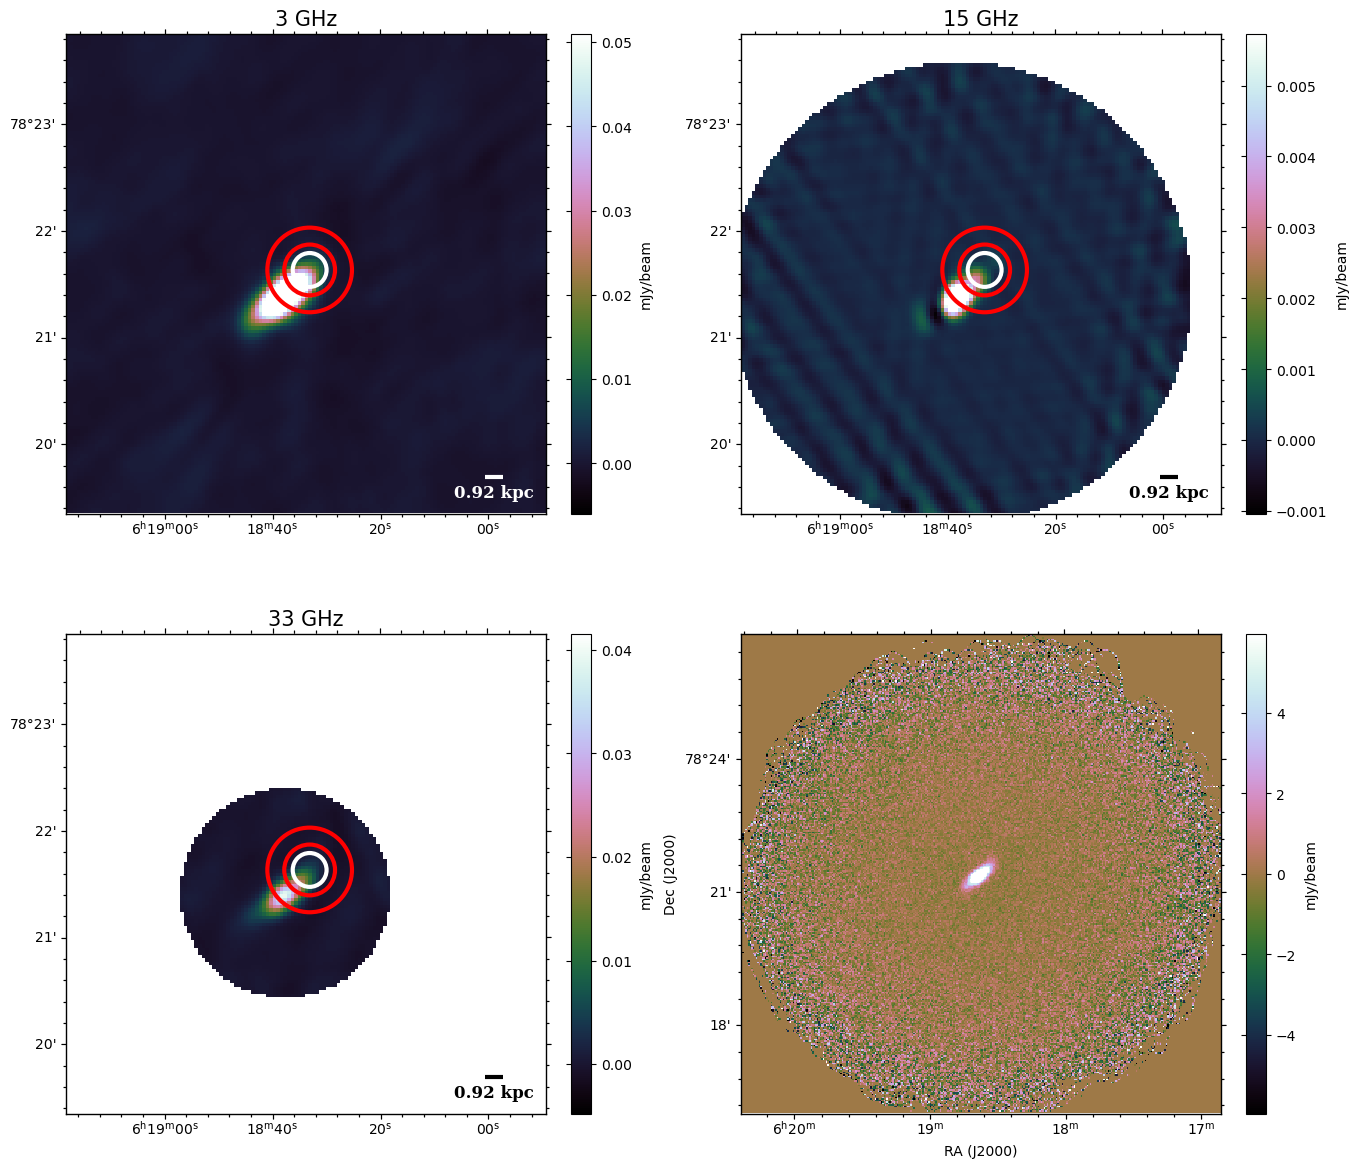

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import aplpy

##########################################################################################################
#function to help us with plotting later on 
def fix_aplpy_fits(aplpy_obj, dropaxis=2):
    """This removes the degenerated dimensions in APLpy 2.X...
    The input must be the object returned by aplpy.FITSFigure().
    `dropaxis` is the index where to start dropping the axis (by default it assumes the 3rd,4th place).
    """
    temp_wcs = aplpy_obj._wcs.dropaxis(dropaxis)
    temp_wcs = temp_wcs.dropaxis(dropaxis)
    aplpy_obj._wcs = temp_wcs
    
##########################################################################################################
#define some constants for making a scalebar    
scale=0.00055556*u.degree #pixel scale in degrees
scalearcsec=scale.to('arcsec') #pixel scale in arcseconds
length=scalearcsec.value*(19e6*u.AU) #convert pixel scale in arcsecs to length in AU
lengthpc=length.to(u.pc) #convert length in AU to length in pc
lengtharcsec=(lengthpc/(19.3e6*u.pc))*u.arcsec #convert length in pc to length in arcsecs
distance=19e6*u.Mpc #define constant for converting distance from AU to pc
pclabel=(distance.value*u.AU).to(u.pc) #create label for scalebar

##########################################################################################################
import sys

tbl
# sys.exit()

for i in range(54):
    for row in tbl:
        print('Working on ' + str(row['Source ID']))
        #set up the subplots
        fig = plt.figure(figsize=(15,15))
        
        #set width and height parameters for recentering
        w=0.075
        h=0.075
        #3 GHz image
        #plot the fits file
        f1 = aplpy.FITSFigure(data=str(row['3 GHz file'])[:-5]+'.fits', figure=fig, subplot=[0.1,0.5,0.35,0.35])
        print(str(row['3 GHz file']))
        fix_aplpy_fits(f1)
        #pick out a colormap to use
        f1.show_colorscale(cmap='cubehelix')
        f1.add_colorbar()
        f1.colorbar.set_pad(0.25)
        #recenter based on pixel coordinates of aperture
        f1.colorbar.set_axis_label_text('mJy/beam')
        f1.recenter(merged_table['RA (deg)'][i:i+1],merged_table['Dec (deg)'][i:i+1],width=w, height=h)
        #plot the aperture and annulus
        f1.show_regions('/users/adignan/regfiles/new/'+str(row['Source ID'])+'_3GHz.reg')
        f1.add_scalebar(10*u.arcsec,label=("%.2f" % ((10*pclabel.value)/(1000)) + ' kpc'))
        f1.scalebar.set(color='white',linewidth=3) 
        f1.scalebar.set_font(size='large', weight='heavy', stretch='normal', family='serif')
        f1.axis_labels.hide()
        f1.set_title('3 GHz',fontsize=15)

        #15 GHz image
        f2 = aplpy.FITSFigure(data=str(row['15 GHz file'])[:-5]+'.fits', figure=fig, subplot=[0.55,0.5,0.35,0.35])
        fix_aplpy_fits(f2)
        f2.show_colorscale(cmap='cubehelix')
        f2.add_colorbar()
        f2.colorbar.set_pad(0.25)
        f2.colorbar.set_axis_label_text('mJy/beam')
        f2.recenter(merged_table['RA (deg)'][i+1:i+2],merged_table['Dec (deg)'][i+1:i+2],width=w, height=h)
        f2.show_regions('/users/adignan/regfiles/new/'+str(row['Source ID'])+'_15GHz.reg')
        f2.add_scalebar(10*u.arcsec,label=("%.2f" % ((10*pclabel.value)/(1000)) + ' kpc'))
        f2.scalebar.set(color='black',linewidth=3)
        f2.scalebar.set_font(size='large', weight='heavy', stretch='normal', family='serif')
        f2.axis_labels.hide()
        f2.set_title('15 GHz',fontsize=15)

        #33 GHz image
        f3 = aplpy.FITSFigure(data=str(row['33 GHz file'])[:-5]+'.fits', figure=fig, subplot=[0.1,0.1,0.35,0.35])
        fix_aplpy_fits(f3)
        f3.show_colorscale(cmap='cubehelix')
        f3.add_colorbar()
        f3.colorbar.set_pad(0.25)
        f3.colorbar.set_axis_label_text('mJy/beam')
        f3.recenter(merged_table['RA (deg)'][i+2:i+3],merged_table['Dec (deg)'][i+2:i+3],width=w, height=h)
        f3.show_regions('/users/adignan/regfiles/new/'+str(row['Source ID'])+'_33GHz.reg')
        f3.add_scalebar(10*u.arcsec,label=("%.2f" % ((10*pclabel.value)/(1000)) + ' kpc'))
        f3.scalebar.set(color='black',linewidth=3)
        f3.scalebar.set_font(size='large', weight='heavy', stretch='normal', family='serif')
        f3.axis_labels.hide()
        f3.set_title('33 GHz',fontsize=15)

        #90 GHz image
        f4 = aplpy.FITSFigure(data=str(row['90 GHz file'])[:-5]+'_copy.fits', figure=fig, subplot=[0.55,0.1,0.35,0.35])
        temp_wcs = f4._wcs.dropaxis(2)
        f4._wcs = temp_wcs
        f4.show_colorscale(cmap='cubehelix')
        f4.add_colorbar()
        f4.colorbar.set_pad(0.25)
        f4.colorbar.set_axis_label_text('mJy/beam')
        f4.recenter(merged_table['RA (deg)'][i+3:i+4],merged_table['Dec (deg)'][i+3:i+4],width=w, height=h)
        f4.show_regions('/users/adignan/regfiles/new/'+str(row['Source ID'])+'_90GHz.reg')
        f4.add_scalebar(10*u.arcsec,label=("%.2f" % ((10*pclabel.value)/(1000)) + ' kpc'))
        f4.scalebar.set(color='white',linewidth=3)
        f4.scalebar.set_font(size='large', weight='heavy', stretch='normal', family='serif')
        f4.axis_labels.hide()
        f4.set_title('90 GHz',fontsize=15)

        plt.suptitle(str(row['Source ID']),fontsize=25,x=0.475,y=0.9)
        
        fig.savefig('/users/adignan/figures/new/'+str(row['Source ID'])+'.png')

        plt.close()
        
        i=i+4

# Creating copies of 90 GHz images for plotting

### There's no way to manually change the colorbar scale, so just change the scale of the data

In [11]:

for row in tbl:
    with fits.open(row['90 GHz file']) as f:
        hdr = f[0].header 
        hdr['BSCALE']=1000.0
        f.writeto(str(row['90 GHz file'])[:-5]+'_copy.fits',overwrite=True)

# Performing photometry (manual)

In [ ]:
###PURPOSE: perform photometry for a given galaxy

#import statements
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus
from photutils.aperture import CircularAperture, CircularAnnulus
import pandas as pd
from astropy import wcs
from photutils import aperture_photometry
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization.wcsaxes import WCSAxes
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
from photutils.aperture import ApertureStats

#read in relevant data files
jy_data = fits.open(path+'NGC2798/Jyperbeam_NGC2798_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits')[0]
# jy_image=fits.getdata(path+'NGC0337/Jyperbeam_NGC0337_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits')[0]

file3=fits.open(path+'NGC2798/ngc2798_3GHz_r0.5_smoothed_ms.fits')[0]
file15=fits.open(path+'NGC2798/ngc2798_15GHz_r0.5_smoothed_ms.fits')[0]
file33=fits.open(path+'NGC2798/ngc2798_33GHz_r0.5_smoothed_ms.fits')[0]

#making a list of the files
files=[file3,file15,file33,jy_data]

#only read in relevant axes
data3=file3.data[0,0,:,:]
data15=file15.data[0,0,:,:]
data33=file33.data[0,0,:,:]
datajy=jy_data.data[0,:,:]

#making a list of the data 
datas=[data3,data15,data33,datajy]

#drop extra non-spatial axes
wcs3=wcs.WCS(file3).dropaxis(3).dropaxis(2)
wcs15=wcs.WCS(file15).dropaxis(3).dropaxis(2)
wcs33=wcs.WCS(file33).dropaxis(3).dropaxis(2)
wcsjy=wcs.WCS(jy_data).dropaxis(2)

#making a list of the WCS info
wcss=[wcs3,wcs15,wcs33,wcsjy]

#read in Sean's catalog
df=pd.read_csv('/lustre/cv/students/adignan/Linden2020_table5.csv')
source=df[df['Source ID']==('NGC2798')]
# source=df.iloc[[143]]

#pull out positions from ra and dec columns
ra=source['RA_J2000']
dec=source['Decl_J2000']

ras=[]
decs=[]

for r in ra:
    r=(r[:2]+'h'+r[3:5]+'m'+r[6:]+'s')
    ras.append(r)
for d in dec:
    d=(d[:3]+'d'+d[4:6]+'m'+d[7:]+'s')
    decs.append(d)

#creating positions for apertures based on Sean's catalog
#defined using sky coordinates since that's what we have (ra and dec)
positions=[]

for r, d in zip(ras,decs):
    position=SkyCoord(ra=r,dec=d)
    positions.append(position)

#need area of aperture, area of beam (arcsec squared)
#divide them to get just beam
#divide this number by photometry to get in units of beam

#value of the major axis of the beam for the target
bmaj=9.528282036*u.arcsec
              
#define aperture with radius == GBT beam (bmaj value)
fwhm = bmaj
rin = 1.5*fwhm 
rout = rin + fwhm

#creating lists of the apertures and annuli (defined in sky coordinates)
skyapertures=[]
skyannuli=[]

for p in positions:
    x1, y1 = wcs3.world_to_pixel(p)
    x2, y2= wcs15.world_to_pixel(p)
    x3, y3 = wcs33.world_to_pixel(p)
    x4, y4=wcsjy.world_to_pixel(p)
    skyaperture = SkyCircularAperture(p, r=fwhm)
    skyannulus = SkyCircularAnnulus(p, rin, rout)
    skyapertures.append(skyaperture)
    skyannuli.append(skyannulus)

#creating list of the apertures defined in pixel coordinates 
#(converting from sky coordinates)
pix_apertures=[]
pix_annuli=[]

for w in wcss:
    for i,j in zip(skyapertures,skyannuli):
        pix_aperture = i.to_pixel(w)
        pix_annulus = j.to_pixel(w)
        pix_apertures.append(pix_aperture)
        pix_annuli.append(pix_annulus)
    
factor=(np.pi*((fwhm.value)**2))/(np.pi/4/np.log(2) * bmaj.value)

# actually performing photometry
# lists=Table(names='aperture_sum')
#initialize empty photometry table   
# for s in skyapertures:
#     for d,w in zip(datas,wcss):
#         row = aperture_photometry(data=d, apertures=s, wcs=w)
#         row['aperture_sum']=row['aperture_sum']/factor 
#         print(row)

results=[]
medians=[]
means=[]
mads=[]
rmss=[]

for ap, ann in zip(skyapertures,skyannuli):
    for d, w in zip((datas),wcss):
        phot=aperture_photometry(data=d,apertures=ap,wcs=w)
        aperstats = ApertureStats(data=d, aperture=ann, wcs=w)
        phot['aperture_sum']=(phot['aperture_sum']/factor)*1000
        results.append(phot)
        medians.append(aperstats.median*1000)
        means.append(aperstats.mean*1000)
        mads.append(aperstats.mad_std*1000)
        rmss.append(np.sqrt(aperstats.mean*1000))

table_stacked = vstack(results)
# table_stacked |= (d)
medianscol=Column(medians,name='median',unit='mJy')
meanscol=Column(means,name='mean',unit='mJy')
madscol=Column(mads,name='mad',unit='mJy')
rmscol=Column(rmss,name='rms',unit='mJy')

table_stacked.add_columns([medianscol,meanscol,madscol,rmscol])

table_stacked['aperture_sum']=Column(data=table_stacked['aperture_sum'],unit='mJy')

# name = Column(, name='freq')
# table_stacked.add_column(freq,index=0)

#read in photometry sources Google Sheet
data = ascii.read('/users/adignan/photometry_sources.csv', format='csv')

#read in Sean's catalog
df = ascii.read('/lustre/cv/students/adignan/Linden2020_table5.csv', format='csv')

minitbl=df[['Source ID','RA_J2000','Decl_J2000']]
tbl=join(data,minitbl,'Source ID')

for row in tbl:
    print(row['Source ID'])

table_stacked
  